## Analiza danych w zadanym formacie

dim, ts_name,     best_value,                 steps_to_best_value

np.

188, PPO_G2_130k, 158810.53550787075, 18135

Set-up

In [120]:
# 1. IMPORTY I KONFIGURACJA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob
import os

MAKE_PLOTS_FOR_DETEMINISTICS = False
MAKE_PLOTS_FOR_HALF_STEPS = True

plt.rcParams['figure.figsize'] = (10, 6)

# 2. Ścieżka do folderu z plikami
folder_path = "./"#Tests/FinalTests/"  # lub np. "./dane/"
if MAKE_PLOTS_FOR_HALF_STEPS:
    if MAKE_PLOTS_FOR_DETEMINISTICS == True:
        pattern = os.path.join(folder_path, "sa_results_half_det_*.csv")
    else:
        pattern = os.path.join(folder_path, "sa_results_half_stoch_*.csv")
else: 
    if MAKE_PLOTS_FOR_DETEMINISTICS == True:
        pattern = os.path.join(folder_path, "sa_results_det_*.csv")
    else:
        pattern = os.path.join(folder_path, "sa_results_stoch_*.csv")


# 3. Wczytywanie i łączenie danych
all_files = glob.glob(pattern)
df_list = []

for file in all_files:
    temp_df = pd.read_csv(file)
    temp_df['source_file'] = os.path.basename(file)  # opcjonalnie: dodaj nazwę pliku jako kolumnę
    df_list.append(temp_df)

# 4. Łączenie w jeden DataFrame
df = pd.concat(df_list, ignore_index=True)

# 3. Krótkie „smoking‑gun”
display(df.head())
display(df.describe(include='all'))

,dim,ts_name,best_value,steps_to_best_value,source_file
0,148,E,96335.161379,1488,sa_results_half_stoch_1.csv
1,148,F_2,98346.870007,643,sa_results_half_stoch_1.csv
2,148,G,98912.811583,787,sa_results_half_stoch_1.csv
3,148,G2,98402.334193,1369,sa_results_half_stoch_1.csv
4,148,G3_1,99315.947410,443,sa_results_half_stoch_1.csv


,dim,ts_name,best_value,steps_to_best_value,source_file
count,206520.000000,206520,206520.000000,206520.000000,206520
unique,NaN,24,NaN,NaN,4
top,NaN,E,NaN,NaN,sa_results_half_stoch_2.csv
freq,NaN,8605,NaN,NaN,90792
mean,174.838582,NaN,167045.191083,3869.859597,NaN
std,72.144090,NaN,122632.351900,5918.648158,NaN
min,50.000000,NaN,8625.393732,0.000000,NaN
25%,113.000000,NaN,57537.042205,546.000000,NaN
50%,174.000000,NaN,139959.249567,1277.500000,NaN
75%,238.000000,NaN,266886.527152,3865.000000,NaN


In [117]:
#Średnia, odchylenie standardowe, min i max dla 'best_value' i 'steps_to_best_value' w grupach ts_name
group_stats = df.groupby('ts_name')[['best_value', 'steps_to_best_value']].agg(['mean', 'std', 'min', 'max'])

# wykonanie różnicy a.x - PPO.x
baseline = group_stats.loc['Const_100']
diff_stats = group_stats.subtract(baseline, axis='columns').multiply(100,axis='columns').divide(baseline, axis='columns')

# Wyświetlenie wyników
styled = diff_stats.style\
    .background_gradient(subset=[('best_value','mean'), ('steps_to_best_value','mean')], cmap='viridis')\
    .format("{:.4f}")

# Aby zobaczyć ją w notebooku:
styled

tabela przedstawia polepszenie lub pogorszenie w % względem wybranego typu sterowania

(x.mean - PPO.mean)/PPO.mean * 100

dodatnia wartość >> PPO_G2 bylo lepsze

ujemna wartość >> PPO_G2 bylo gorsze

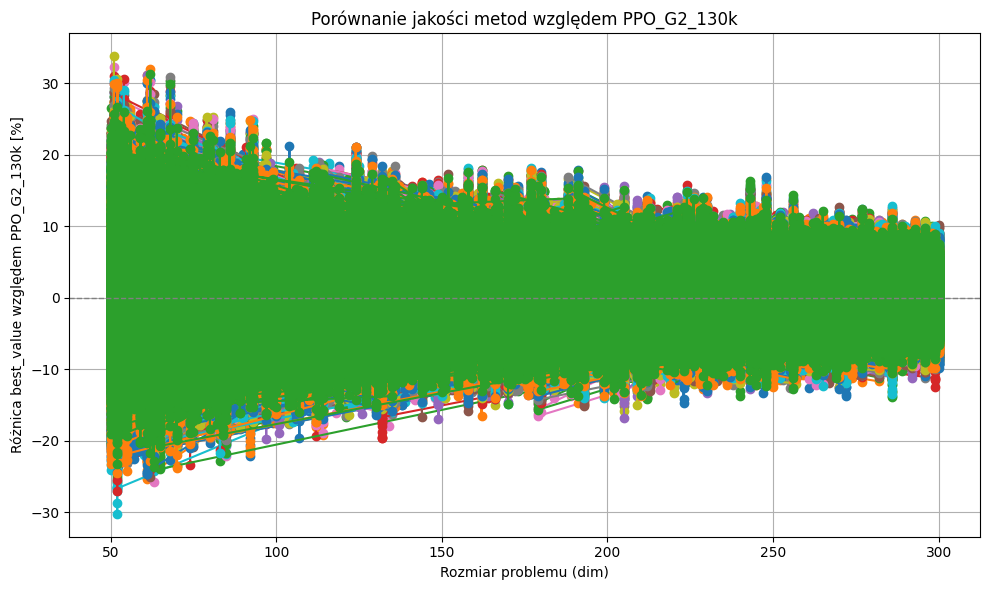

In [32]:
# (1) Tworzymy nową kolumnę: % różnicy względem PPO_G2_130k
df_pct = df.copy()

# Łączymy oryginalne z wersją PPO_G2
ppo_ref = df[df['ts_name'] == 'G4_1'][['dim', 'best_value']].rename(columns={'best_value': 'ppo_value'})

# (2) Merge po dim: każdemu wierszowi dodajemy wartość PPO_G2_130k z tego samego wymiaru
df_pct = df_pct.merge(ppo_ref, on='dim')

# (3) Obliczamy % różnicy
df_pct['diff_pct'] = (df_pct['best_value'] - df_pct['ppo_value']) / df_pct['ppo_value'] * 100

# (4) Filtrujemy tylko metody różne od PPO_G2_130k (bo różnica = 0)
df_plot = df_pct[df_pct['ts_name'] != 'G4_1']

# (5) Wykres
plt.figure(figsize=(10, 6))
for method in df_plot['ts_name'].unique():
    method_data = df_plot[df_plot['ts_name'] == method]
    plt.plot(method_data['dim'], method_data['diff_pct'], marker='o', label=method)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Rozmiar problemu (dim)")
plt.ylabel("Różnica best_value względem PPO_G2_130k [%]")
plt.title("Porównanie jakości metod względem PPO_G2_130k")
#plt.legend(title="Metoda sterowania temperaturą")
plt.grid(True)
plt.tight_layout()
plt.show()